# not changed for before

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline

In [2]:
def max_pooling_batch(matrices, new_shape):
    original_batch, original_height, original_width = matrices.shape  
    target_height, target_width = new_shape
    pool_size = original_width // target_width
    reshaped = matrices.reshape(original_batch, original_height, target_width, pool_size)
    pooled = np.max(reshaped, axis=3)
    return pooled

def count_and_percentage(array):
    flattened = array.flatten()
    unique, counts = np.unique(flattened, return_counts=True)
    total_elements = flattened.size
    count_dict = dict(zip(unique, counts))
    percentage_dict = {key: (value / total_elements) * 100 for key, value in count_dict.items()}
    return count_dict, percentage_dict

def resize_tensor_bilinear(tensor, target_size, mode='bilinear'):
    tensor = tensor.unsqueeze(0)
    resized = F.interpolate(tensor, size=target_size, mode=mode, align_corners=False)
    return resized.squeeze(0)

def resize_tensor_nearest(tensor, target_size, mode='nearest'):
    tensor = tensor.unsqueeze(0)
    resized = F.interpolate(tensor, size=target_size, mode=mode)
    return resized.squeeze(0)


def normalize_tensor(tensor):
    min_val = tensor.min(dim=-1, keepdim=True).values.min(dim=-2, keepdim=True).values
    max_val = tensor.max(dim=-1, keepdim=True).values.max(dim=-2, keepdim=True).values
    return ((tensor - min_val) / ((max_val - min_val) + 1e-8))

In [3]:
#ELEVATION DATA
elevation_data = np.load('elevation_matrix.npy') 

#VEGETATION DATA
vegetation_data = np.load('NLCD2021_OR.npy') 

#SOIL VARIABLE DATA
directory = "ERA5_matrices"  
npy_files = sorted([f for f in os.listdir(directory) if f.endswith('.npy')])
matrices = [np.load(os.path.join(directory, file)) for file in npy_files]
data = np.stack(matrices, axis=0)  # Shape: (num_files, height, width)
soil_variable_data = np.transpose(data, (1, 0, 2, 3)) 

#SOIL COMPOSITION DATA
data_folder = "SOLUS"
npy_files = [f for f in os.listdir(data_folder) if f.endswith('.npy')]
num_files = len(npy_files)
transformed_data_list = []
pca = PCA(n_components=1)
for file in npy_files:
    file_path = os.path.join(data_folder, file)
    soil_data = np.load(file_path)
    try:
        reshaped_data = soil_data.reshape(7, -1).T
    except:
        print(file)
        continue
    principal_component = pca.fit_transform(reshaped_data)  
    reduced_data = principal_component.reshape(1306, 464)
    transformed_data_list.append(reduced_data)
soil_composition_data = np.stack(transformed_data_list, axis=0) 

anylithicdpt_2D_matrix.npy
resdept_2D_matrix.npy


In [4]:
print(f"ELEVATION DATA : {elevation_data.shape}")
print(f"VEGETATION DATA : {vegetation_data.shape}")
print(f"SOIL VARIABLE DATA : {soil_variable_data.shape}")
print(f"SOIL COMPOSITION DATA : {soil_composition_data.shape}")

ELEVATION DATA : (10812, 10812)
VEGETATION DATA : (15, 4353, 1547)
SOIL VARIABLE DATA : (1096, 28, 5, 5)
SOIL COMPOSITION DATA : (18, 1306, 464)


In [5]:
label = np.load('landslide_labels_stored_sequentially_compressed.npz') 
output_labels = label['matrix']
labels_resized = max_pooling_batch(output_labels, (120, 120))  # Output shape: (1096, 120, 120)
counts, percentages = count_and_percentage(labels_resized)
print("Counts:", counts)  
print("Percentages:", percentages)

Counts: {0.0: 15118676, 1.0: 303439, 2.0: 360285}
Percentages: {0.0: 95.79453061638281, 1.0: 1.9226416768045418, 2.0: 2.282827706812652}


In [6]:
print(f"OUTPUT LABELS : {labels_resized.shape}")

OUTPUT LABELS : (1096, 120, 120)


In [7]:
spatial_mask = np.load('spatial_mask.npy') 
spatial_mask = torch.tensor(spatial_mask, dtype=torch.float)
spatial_mask.to(device)

torch.Size([120, 120])

In [8]:
elevation_data = torch.tensor(elevation_data, dtype=torch.float).unsqueeze(0)  # (1, 10812, 10812)
vegetation_data = torch.tensor(vegetation_data, dtype=torch.float)             # (15, 4353, 1547)
soil_composition_data = torch.tensor(soil_composition_data, dtype=torch.float) # (18, 1306, 464)
soil_variable_data = torch.tensor(soil_variable_data, dtype=torch.float)       # (1096, 28, 5, 5)
output_labels = torch.tensor(labels_resized, dtype=torch.long)                 # (1096, 120, 120)

In [9]:
print(f"ELEVATION DATA : {elevation_data.shape}")
print(f"VEGETATION DATA : {vegetation_data.shape}")
print(f"SOIL VARIABLE DATA : {soil_variable_data.shape}")
print(f"SOIL COMPOSITION DATA : {soil_composition_data.shape}")
print(f"OUTPUT LABELS : {output_labels.shape}")

ELEVATION DATA : torch.Size([1, 10812, 10812])
VEGETATION DATA : torch.Size([15, 4353, 1547])
SOIL VARIABLE DATA : torch.Size([1096, 28, 5, 5])
SOIL COMPOSITION DATA : torch.Size([18, 1306, 464])
OUTPUT LABELS : torch.Size([1096, 120, 120])


# my changes

In [10]:
class DayDataset(Dataset):
    def __init__(self, day_indices, vegetation, elevation, soil_comp, soil_var, labels):
        """
        Args:
          day_indices: list of day indices (e.g., [0, 1, 2, ...])
          vegetation: static vegetation data, already resized, shape (15, target_H, target_W)
          elevation: static elevation data, already resized, shape (1, target_H, target_W)
          soil_comp: static soil composition data, already resized, shape (18, target_H, target_W)
          soil_var: daily soil variable data, shape (1096, 28, 5, 5)
          labels: daily output labels, shape (1096, target_H, target_W)
          target_size: the target spatial size (target_H, target_W) for all inputs
        """
        self.day_indices = day_indices
        self.vegetation = vegetation
        self.elevation = elevation
        self.soil_comp = soil_comp
        self.soil_var = soil_var
        self.labels = labels

    def __len__(self):
        return len(self.day_indices)

    def __getitem__(self, idx):
        day = self.day_indices[idx]
        soil_var_day = self.soil_var[day] 
        #input_tensor = torch.cat([self.vegetation, self.elevation, self.soil_comp, soil_variable_normalized], dim=0)
        label = self.labels[day]
        
        return self.vegetation, self.elevation, self.soil_comp, soil_var_day, label

In [11]:
# all_days = list(range(1096))
# train_days = list(range(0, 730))
# test_days = list(range(730, 1096))
# val_days = train_days[-100:] 
# train_days = train_days[:-100]
all_days = list(range(1096))
train_days = list(range(0, 730))
test_days = list(range(730, 1096))
val_days = random.sample(train_days, 100) # Randomly select 100 days from train_days for validation
train_days = [day for day in train_days if day not in val_days] # Remove the selected validation days from train_days

In [12]:
train_dataset = DayDataset(train_days, vegetation_data, elevation_data,
                           soil_composition_data, soil_variable_data, output_labels)

In [13]:
len(train_dataset[0])

5

In [14]:
val_dataset = DayDataset(val_days, vegetation_data, elevation_data,
                           soil_composition_data, soil_variable_data, output_labels)
test_dataset = DayDataset(test_days, vegetation_data, elevation_data,
                           soil_composition_data, soil_variable_data, output_labels)

In [15]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
from MutliModalFCN import *

In [17]:
num_classes = 3
model = FCN(4, num_classes)
model_veg = VegetationConvNet()
model_elevation = ElevationConvNet()
model_ERA = ERA5ConvNet()
model_solus = SOLUSConvNet()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model_veg.to(device)
model_elevation.to(device)
model_ERA.to(device)
model_solus.to(device)

In [18]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [19]:
import torch
import torch.nn.functional as F

class MaskedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, class_weights=None):
        super(MaskedCrossEntropyLoss, self).__init__()
        # If class weights are provided, store them as a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights).float()
        else:
            self.class_weights = None
            
            
    def forward(self, outputs, labels, spatial_mask):
        # Flatten the outputs, labels, and spatial_mask
        B, C, H, W = outputs.shape
        outputs_flat = outputs.view(B, C, -1)  # shape: (B, C, H*W)
        labels_flat = labels.view(B, -1)  # shape: (B, H*W)
        
        # Expand the spatial mask to match the shape of outputs (B, H, W)
        spatial_mask_expanded = spatial_mask.unsqueeze(0).expand(B, -1, -1)  # shape: (B, H, W)
        spatial_mask_flat = spatial_mask_expanded.view(B, -1)  # shape: (B, H*W)

        # Apply the spatial mask (only consider masked positions)
        mask_indices = spatial_mask_flat == 1

        # Flatten the outputs and labels to (B*H*W, C) and (B*H*W,)
        outputs_flat = outputs_flat.view(-1, C)  # shape: (B*H*W, C)
        labels_flat = labels_flat.view(-1)  # shape: (B*H*W,)
        
        # Apply mask to the flattened outputs and labels
        masked_outputs = outputs_flat[mask_indices.view(-1)]
        masked_labels = labels_flat[mask_indices.view(-1)]

        # Calculate the cross-entropy loss only on masked positions
        if masked_outputs.size(0) > 0:  # Avoid division by zero
            loss = F.cross_entropy(masked_outputs, masked_labels, weight=self.class_weights)
        else:
            loss = torch.tensor(0.0).to(outputs.device)

        return loss


In [20]:
freq = torch.tensor([0.923, 0.038, 0.039])
weights = 1.0 / freq
weights = weights / weights.sum()

criterion = MaskedCrossEntropyLoss(class_weights = weights)  
optimizer = optim.AdamW(list(model.parameters())+list(model_veg.parameters())+list(model_elevation.parameters())+
                        list(model_ERA.parameters())+list(model_solus.parameters()), lr=0.01, weight_decay=0.0001)
early_stopping = EarlyStopping(patience=15, delta=0.01)

/tmp/ipykernel_1530028/753182092.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights).float()


In [21]:
import time

start = time.time()
num_epochs = 1000
train_losses = []
val_losses = []

# Early stopping parameters
patience = 15 # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize best validation loss as a large number
patience_counter = 0.0 # Counter for epochs with no improvement

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs in train_loader:
        labels = inputs[-1].to(device)
        
        optimizer.zero_grad()
        
        veg = model_veg(inputs[0].to(device))
        elevation = model_elevation(inputs[1].squeeze(1).to(device))
        era = model_ERA(inputs[3].to(device))
        solus = model_solus(inputs[2].to(device))
        
        outputs = model(torch.stack((veg, elevation, era, solus), dim=1))      # shape: (B, 3, 120, 120)
        loss = criterion(outputs, labels, spatial_mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs[0].size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            labels = inputs[-1].to(device)
            
            veg = model_veg(inputs[0].to(device))
            elevation = model_elevation(inputs[1].squeeze(1).to(device))
            era = model_ERA(inputs[3].to(device))
            solus = model_solus(inputs[2].to(device))
            
            outputs = model(torch.stack((veg, elevation, era, solus), dim=1))
            loss = criterion(outputs, labels, spatial_mask)
            val_loss += loss.item() * inputs[0].size(0)
    epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # Reset counter if we have improvement
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
            break

epochs_run = epoch + 1

end = time.time()
duration = (end-start)/60
print(f"The training loop ran for {round(duration,2)} minutes for {epochs_run} epochs.")


Epoch 1/1000  Train Loss: 1.1071  Val Loss: 1.0202
Epoch 2/1000  Train Loss: 0.9545  Val Loss: 0.9225
Epoch 3/1000  Train Loss: 0.9098  Val Loss: 0.9076
Epoch 4/1000  Train Loss: 0.8893  Val Loss: 0.8900
Epoch 5/1000  Train Loss: 0.8834  Val Loss: 0.8746
Epoch 6/1000  Train Loss: 0.8696  Val Loss: 0.9024
Epoch 7/1000  Train Loss: 0.8635  Val Loss: 0.8774
Epoch 8/1000  Train Loss: 0.8575  Val Loss: 0.8708
Epoch 9/1000  Train Loss: 0.8514  Val Loss: 0.8870
Epoch 10/1000  Train Loss: 0.8486  Val Loss: 0.8665
Epoch 11/1000  Train Loss: 0.8491  Val Loss: 0.8812
Epoch 12/1000  Train Loss: 0.8512  Val Loss: 0.8724
Epoch 13/1000  Train Loss: 0.8479  Val Loss: 0.8543
Epoch 14/1000  Train Loss: 0.8439  Val Loss: 0.8549
Epoch 15/1000  Train Loss: 0.8442  Val Loss: 0.8649
Epoch 16/1000  Train Loss: 0.8461  Val Loss: 0.8614
Epoch 17/1000  Train Loss: 0.8448  Val Loss: 0.8583
Epoch 18/1000  Train Loss: 0.8419  Val Loss: 0.8592
Epoch 19/1000  Train Loss: 0.8418  Val Loss: 0.8519
Epoch 20/1000  Train 

KeyboardInterrupt: 

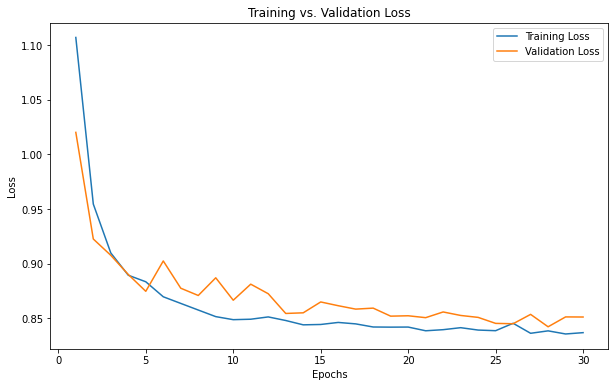

In [24]:
import matplotlib.pyplot as plt
#with new weighted loss
epochs = list(range(1, 31))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

In [25]:
def compute_iou(pred, target, num_classes=3):
    """
    Compute the Intersection over Union (IoU) for each class.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      list: IoU for each class.
    """
    ious = []
    # Flatten the tensors for easier computation.
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = pred_inds.sum().float() + target_inds.sum().float() - intersection
        if union == 0:
            ious.append(float('nan'))  # Alternatively, you might want to append 0.0
        else:
            ious.append((intersection / union).item())
    return ious

def compute_dice(pred, target, num_classes=3):
    """
    Compute the Dice coefficient for each class.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      list: Dice coefficient for each class.
    """
    dices = []
    # Flatten the tensors.
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        total = pred_inds.sum().float() + target_inds.sum().float()
        if total == 0:
            dices.append(float('nan'))
        else:
            dices.append((2 * intersection / total).item())
    return dices

def compute_confusion_matrix(pred, target, num_classes=3):
    """
    Compute a confusion matrix where the rows correspond to true classes
    and the columns correspond to predicted classes.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      torch.Tensor: A (num_classes, num_classes) confusion matrix.
    """
    pred = pred.view(-1)
    target = target.view(-1)
    # Use torch.bincount to count occurrences of each (true, pred) pair.
    cm = torch.bincount(num_classes * target + pred, minlength=num_classes**2)
    cm = cm.reshape(num_classes, num_classes)
    return cm

def compute_precision_recall_f1(conf_matrix):
    """
    Compute per-class precision, recall, and F1 score from a confusion matrix.
    Args:
      conf_matrix (torch.Tensor): A (num_classes, num_classes) confusion matrix.
    Returns:
      tuple: Three lists containing precision, recall, and F1 score for each class.
    """
    num_classes = conf_matrix.shape[0]
    precisions = []
    recalls = []
    f1s = []
    for i in range(num_classes):
        TP = conf_matrix[i, i].item()
        FP = conf_matrix[:, i].sum().item() - TP
        FN = conf_matrix[i, :].sum().item() - TP
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else float('nan')
        recall    = TP / (TP + FN) if (TP + FN) > 0 else float('nan')
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else float('nan')
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    return precisions, recalls, f1s

In [29]:
# with new weighted loss
model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs in test_loader:
        labels = inputs[-1]
        
        optimizer.zero_grad()
        
        veg = model_veg(inputs[0])
        elevation = model_elevation(inputs[1].squeeze(1))
        era = model_ERA(inputs[3])
        solus = model_solus(inputs[2])
        
        outputs = model(torch.stack((veg, elevation, era, solus), dim=1))      # shape: (B, 3, 120, 120)
        
        loss = criterion(outputs, labels, spatial_mask)
        test_loss += loss.item() * inputs[0].size(0)
        
        # Convert raw logits to predicted class labels (shape: (batch_size, H, W))
        preds = torch.argmax(outputs, dim=1)
        
        # Collect predictions and ground truth labels for metric computations
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Calculate average test loss over the dataset
test_loss = test_loss / len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Concatenate all the collected predictions and labels along the batch dimension
all_preds = torch.cat(all_preds, dim=0)
print(all_preds.shape)
all_labels = torch.cat(all_labels, dim=0)
print(all_labels.shape)


# Compute metrics using the functions defined earlier
ious = compute_iou(all_preds, all_labels, num_classes=3)
dices = compute_dice(all_preds, all_labels, num_classes=3)
conf_matrix = compute_confusion_matrix(all_preds, all_labels, num_classes=3)
precisions, recalls, f1s = compute_precision_recall_f1(conf_matrix)

print("IoU per class:", ious)
print("Dice per class:", dices)
print("Confusion Matrix:\n", conf_matrix)
print("Precision per class:", precisions)
print("Recall per class:", recalls)
print("F1 per class:", f1s)


Test Loss: 0.8738
torch.Size([366, 120, 120])
torch.Size([366, 120, 120])
IoU per class: [0.435091108083725, 0.017175473272800446, 0.01975046657025814]
Dice per class: [0.6063602566719055, 0.03377091512084007, 0.03873588144779205]
Confusion Matrix:
 tensor([[2244518,  433006, 2387351],
        [  39761,    9175,   40957],
        [  54095,   11293,   50244]])
Precision per class: [0.9598627080184778, 0.020232692502767522, 0.020271513367482303]
Recall per class: [0.4431536809891656, 0.10206578932731136, 0.43451639684516397]
F1 per class: [0.6063602615554332, 0.033770913581428384, 0.03873587995300256]
